In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from sklearn.metrics import r2_score

# XGBoost import
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import pickle

# grid_cv import
from sklearn.model_selection import GridSearchCV



In [2]:
df= pd.read_csv('data/price/price_baechoo.csv')
# df 구분 인덱스로 설정
df.set_index('구분', inplace=True)

# 평균 컬럼 가격 컬럼으로 변경
df.rename(columns={'평균':'가격'}, inplace=True)

df

,가격
구분,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-12-14,5430.5
2022-12-15,5430.5
2022-12-16,5304.0


In [3]:
# train, test 데이터 분리 (train: 2000부터 2022-10, test: 2022-11)
df_train = df.loc['2000':'2022-11']
df_test = df.loc['2022-11':'2022-12']

In [4]:
df_test

,가격
구분,
2022-11-01,7350.0
2022-11-02,6835.5
2022-11-03,7142.0
2022-11-04,7381.5
2022-11-07,7330.0
2022-11-08,7193.5
2022-11-09,6760.0
2022-11-10,6952.0
2022-11-11,6992.0


In [5]:
df_train

,가격
구분,
2000-01-03,5600.0
2000-01-04,5600.0
2000-01-05,5620.0
2000-01-06,5700.0
2000-01-07,5670.0
...,...
2022-10-25,8172.0
2022-10-26,8072.0
2022-10-27,8252.0


연속적으로 5개 층이 밀리는 방식

In [25]:
candle_df1= pd.DataFrame(columns=['시가', '고가', '저가', '종가', '가격', '날짜'])
num= 0

for i in range(5, len(df_train)):
    test_df1= df_train.iloc[i-5:i]
    candle_df1.loc[num, '시가']= test_df1.iloc[0]['가격']
    candle_df1.loc[num, '고가']= test_df1.max()['가격']
    candle_df1.loc[num, '저가']= test_df1.min()['가격']
    candle_df1.loc[num, '종가']= df_train.iloc[i-1]['가격']
    candle_df1.loc[num, '가격']= df_train.iloc[i]['가격']
    candle_df1.loc[num, '날짜']= df_train.index[i]
    num += 1

candle_df1= candle_df1.set_index('날짜')

candle_df1

,시가,고가,저가,종가,가격
날짜,,,,,
2000-01-08,5600.0,5700.0,5600.0,5670.0,5770.0
2000-01-10,5600.0,5770.0,5600.0,5770.0,5790.0
2000-01-11,5620.0,5790.0,5620.0,5790.0,5740.0
2000-01-12,5700.0,5790.0,5670.0,5740.0,5630.0
2000-01-13,5670.0,5790.0,5630.0,5630.0,5630.0
...,...,...,...,...,...
2022-10-25,9706.0,9706.0,8583.0,8663.0,8172.0
2022-10-26,9193.0,9193.0,8172.0,8172.0,8072.0
2022-10-27,9043.0,9043.0,8072.0,8072.0,8252.0


In [6]:
candle_df= pd.DataFrame(columns=['시가', '고가', '저가', '종가', '날짜'])
num= 0

for i in range(5, len(df_train)):
    test_df= df_train.iloc[i-5:i]
    candle_df.loc[num, '시가']= test_df.iloc[0]['가격']
    candle_df.loc[num, '고가']= test_df.max()['가격']
    candle_df.loc[num, '저가']= test_df.min()['가격']
    candle_df.loc[num, '종가']= df_train.iloc[i]['가격']
    candle_df.loc[num, '날짜']= df_train.index[i]
    num += 1

candle_df= candle_df.set_index('날짜')

candle_df


,시가,고가,저가,종가,날짜
0,5600.0,5700.0,5600.0,5770.0,2000-01-08
1,5600.0,5770.0,5600.0,5790.0,2000-01-10
2,5620.0,5790.0,5620.0,5740.0,2000-01-11
3,5700.0,5790.0,5670.0,5630.0,2000-01-12
4,5670.0,5790.0,5630.0,5630.0,2000-01-13
...,...,...,...,...,...
5850,9706.0,9706.0,8583.0,8172.0,2022-10-25
5851,9193.0,9193.0,8172.0,8072.0,2022-10-26
5852,9043.0,9043.0,8072.0,8252.0,2022-10-27
5853,8583.0,8663.0,8072.0,7916.0,2022-10-28


In [7]:
candle_df= candle_df.set_index('날짜')
candle_df

,시가,고가,저가,종가
날짜,,,,
2000-01-08,5600.0,5700.0,5600.0,5770.0
2000-01-10,5600.0,5770.0,5600.0,5790.0
2000-01-11,5620.0,5790.0,5620.0,5740.0
2000-01-12,5700.0,5790.0,5670.0,5630.0
2000-01-13,5670.0,5790.0,5630.0,5630.0
...,...,...,...,...
2022-10-25,9706.0,9706.0,8583.0,8172.0
2022-10-26,9193.0,9193.0,8172.0,8072.0
2022-10-27,9043.0,9043.0,8072.0,8252.0


In [26]:
feature= candle_df1[['시가', '고가', '저가', '종가']]
target= candle_df1[['가격']]

# feature, target 데이터 스케일링
scaler1_1= MinMaxScaler()
scaler1_2= MinMaxScaler()

feature_sc= scaler1_1.fit_transform(feature)
target_sc= scaler1_2.fit_transform(target)

feature_sc= pd.DataFrame(feature_sc, columns=feature.columns, index=feature.index)
target_sc= pd.DataFrame(target_sc, columns=target.columns, index=target.index)

feature_sc

,시가,고가,저가,종가
날짜,,,,
2000-01-08,0.106796,0.108828,0.119121,0.108738
2000-01-10,0.106796,0.110772,0.119121,0.111512
2000-01-11,0.107351,0.111327,0.119740,0.112067
2000-01-12,0.109570,0.111327,0.121287,0.110680
2000-01-13,0.108738,0.111327,0.120050,0.107628
...,...,...,...,...
2022-10-25,0.220693,0.220044,0.211417,0.191761
2022-10-26,0.206463,0.205802,0.198700,0.178141
2022-10-27,0.202302,0.201638,0.195606,0.175368


In [8]:
feature= candle_df[['시가', '고가', '저가']]
target= candle_df[['종가']]

# feature, target 데이터 스케일링
scaler1= MinMaxScaler()
scaler2= MinMaxScaler()

feature_sc= scaler1.fit_transform(feature)
target_sc= scaler2.fit_transform(target)

feature_sc= pd.DataFrame(feature_sc, columns=feature.columns, index=feature.index)
target_sc= pd.DataFrame(target_sc, columns=target.columns, index=target.index)

feature_sc

,시가,고가,저가
날짜,,,
2000-01-08,0.106796,0.108828,0.119121
2000-01-10,0.106796,0.110772,0.119121
2000-01-11,0.107351,0.111327,0.119740
2000-01-12,0.109570,0.111327,0.121287
2000-01-13,0.108738,0.111327,0.120050
...,...,...,...
2022-10-25,0.220693,0.220044,0.211417
2022-10-26,0.206463,0.205802,0.198700
2022-10-27,0.202302,0.201638,0.195606


In [27]:
#  train, test 데이터 분리
train_X, test_X, train_y, test_y= train_test_split(feature_sc, target_sc, test_size=0.2, shuffle=False)

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (4684, 4) (4684, 1)
테스트 데이터의 크기 : (1171, 4) (1171, 1)


In [9]:
#  train, test 데이터 분리
train_X, test_X, train_y, test_y= train_test_split(feature_sc, target_sc, test_size=0.2, shuffle=False)

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (4684, 3) (4684, 1)
테스트 데이터의 크기 : (1171, 3) (1171, 1)


In [28]:
#find best params for XGBoost ,XGBoost 모델을 만든다
xgb = XGBRegressor()

# XGBoost 모델의 하이퍼파라미터를 설정한다
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

# XGBoost 모델의 하이퍼파라미터를 최적화한다
grid_cv = GridSearchCV(xgb, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(train_X, train_y)

# 최적의 하이퍼파라미터를 출력한다
print('최적의 하이퍼파라미터:', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

In [ ]:
# 최적의 하이퍼파라미터를 사용하여 XGBoost 모델을 만든다
xgb = XGBRegressor(n_estimators=grid_cv.best_params_['n_estimators'],
                  learning_rate=grid_cv.best_params_['learning_rate'],   
                  max_depth=grid_cv.best_params_['max_depth'],
                  colsample_bytree=grid_cv.best_params_['colsample_bytree'],
                  subsample=grid_cv.best_params_['subsample'],
                  reg_alpha=grid_cv.best_params_['reg_alpha'],
                  reg_lambda=grid_cv.best_params_['reg_lambda'])

# XGBoost 모델을 학습한다
xgb.fit(train_X, train_y)

# XGBoost 모델을 평가한다
y_pred = xgb.predict(test_X)
print('XGBoost 모델의 RMSE:', np.sqrt(mean_squared_error(test_y, y_pred)))

# r2_score
print('XGBoost 모델의 r2_score:', r2_score(test_y, y_pred))


XGBoost 모델의 RMSE: 0.04388296495588513
XGBoost 모델의 r2_score: 0.9135358224243552


In [ ]:
# 모델 저장
pickle.dump(xgb, open('model/xgb_model.pkl', 'wb'))

# scaler 저장
pickle.dump(scaler1, open('model/scaler1.pkl', 'wb'))
pickle.dump(scaler2, open('model/scaler2.pkl', 'wb'))


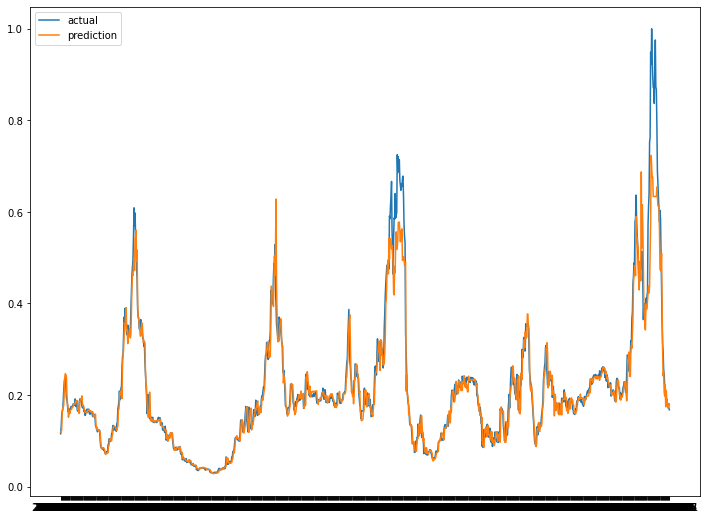

In [12]:
# 시각화
plt.figure(figsize=(12, 9))
plt.plot(test_y, label='actual')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()




Make new data

In [ ]:
# 예측 데이터 생성
candle_test_df1= pd.DataFrame(columns=['시가', '고가', '저가', '종가', '가격', '날짜'])
num= 0

for i in range(5, len(df_test)):
    test_df1_1= df_test.iloc[i-5:i]
    candle_test_df1.loc[num, '시가']= test_df1_1.iloc[0]['가격']
    candle_test_df1.loc[num, '고가']= test_df1_1.max()['가격']
    candle_test_df1.loc[num, '저가']= test_df1_1.min()['가격']
    candle_test_df1.loc[num, '종가']= df_test.iloc[i-1]['가격']
    candle_test_df1.loc[num, '가격']= df_test.iloc[i]['가격']
    candle_test_df1.loc[num, '날짜']= df_test.index[i]
    num += 1

candle_test_df1= candle_test_df1.set_index('날짜')

candle_test_df1

In [14]:
# 예측 데이터 생성
candle_test_df= pd.DataFrame(columns=['시가', '고가', '저가', '종가', '날짜'])
num= 0

for i in range(5, len(df_test)):
    test_df=df_test.iloc[i-5:i]
    candle_test_df.loc[num, '시가']= test_df.iloc[0]['가격']
    candle_test_df.loc[num, '고가']= test_df.max()['가격']
    candle_test_df.loc[num, '저가']= test_df.min()['가격']
    candle_test_df.loc[num, '종가']=df_test.iloc[i]['가격']
    candle_test_df.loc[num, '날짜']=df_test.index[i]
    num += 1

candle_test_df= candle_test_df.set_index('날짜')

candle_test_df

,시가,고가,저가,종가
날짜,,,,
2022-11-08,7350.0,7381.5,6835.5,7193.5
2022-11-09,6835.5,7381.5,6835.5,6760.0
2022-11-10,7142.0,7381.5,6760.0,6952.0
2022-11-11,7381.5,7381.5,6760.0,6992.0
2022-11-14,7330.0,7330.0,6760.0,6724.0
2022-11-15,7193.5,7193.5,6724.0,6684.0
2022-11-16,6760.0,6992.0,6684.0,6900.0
2022-11-17,6952.0,6992.0,6684.0,6432.0
2022-11-18,6992.0,6992.0,6432.0,7018.0


In [ ]:
feature1= candle_test_df1[['시가', '고가', '저가', '종가']]
target1= candle_test_df1[['가격']]

feature1_sc= scaler1_1.fit_transform(feature1)
target1_sc= scaler1_2.fit_transform(target1)

feature1_sc= pd.DataFrame(feature1_sc, columns=feature1.columns, index=feature1.index)
target1_sc= pd.DataFrame(target1_sc, columns=target1.columns, index=target1.index)

feature1_sc

In [15]:
feature= candle_test_df[['시가', '고가', '저가']]
target= candle_test_df[['종가']]

feature_sc= scaler1.fit_transform(feature)
target_sc= scaler2.fit_transform(target)

feature_sc= pd.DataFrame(feature_sc, columns=feature.columns, index=feature.index)
target_sc= pd.DataFrame(target_sc, columns=target.columns, index=target.index)

feature_sc

,시가,고가,저가
날짜,,,
2022-11-08,0.975419,1.000000,1.000000
2022-11-09,0.573937,1.000000,1.000000
2022-11-10,0.813110,1.000000,0.939284
2022-11-11,1.000000,1.000000,0.939284
2022-11-14,0.959813,0.959813,0.939284
2022-11-15,0.853297,0.853297,0.910334
2022-11-16,0.515021,0.696059,0.878166
2022-11-17,0.664846,0.696059,0.878166
2022-11-18,0.696059,0.696059,0.675513


In [ ]:
# XGBoost 모델을 평가한다
y_pred_test = xgb.predict(feature1_sc)
print('XGBoost 모델의 RMSE:', np.sqrt(mean_squared_error(target1_sc, y_pred_test)))

# r2_score
print('XGBoost 모델의 r2_score:', r2_score(target1_sc, y_pred_test))

In [16]:
# XGBoost 모델을 평가한다
y_pred = xgb.predict(feature_sc)
print('XGBoost 모델의 RMSE:', np.sqrt(mean_squared_error(target_sc, y_pred)))

# r2_score
print('XGBoost 모델의 r2_score:', r2_score(target_sc, y_pred))

XGBoost 모델의 RMSE: 0.19334122933148973
XGBoost 모델의 r2_score: 0.5222305088521442


In [ ]:
y_pred_test= y_pred_test.reshape(-1,1)

# 예측 데이터 스케일링 복원
pred_test_y= scaler1_2.inverse_transform(y_pred_test)

# 실제 데이터 스케일링 복원
target_test_sc= scaler1_2.inverse_transform(target_sc)

#시각화
plt.figure(figsize=(12, 9))
plt.plot(pred_test_y, label='actual')
plt.plot(target1_sc, label='prediction')
plt.legend()
plt.show()

In [19]:
y_pred= y_pred.reshape(-1,1)

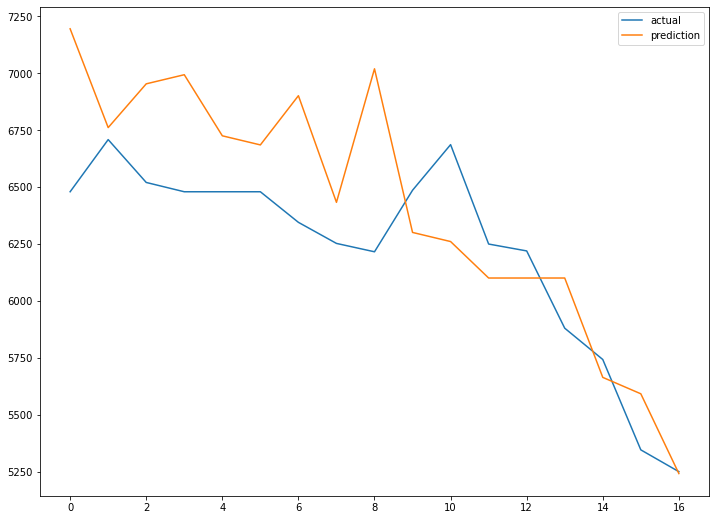

In [20]:
# 예측 데이터 스케일링 복원
pred_test_y= scaler2.inverse_transform(y_pred)

# 실제 데이터 스케일링 복원
target_test_sc= scaler2.inverse_transform(target_sc)

#시각화
plt.figure(figsize=(12, 9))
plt.plot(pred_test_y, label='actual')
plt.plot(target_test_sc, label='prediction')
plt.legend()
plt.show()

In [ ]:
#  오차율 계산
diff1= ((pred_test_y - target1_sc)/ target1_sc)*100

# 오차율 시각화
plt.figure(figsize=(12, 9))
plt.plot(diff1)
plt.show()

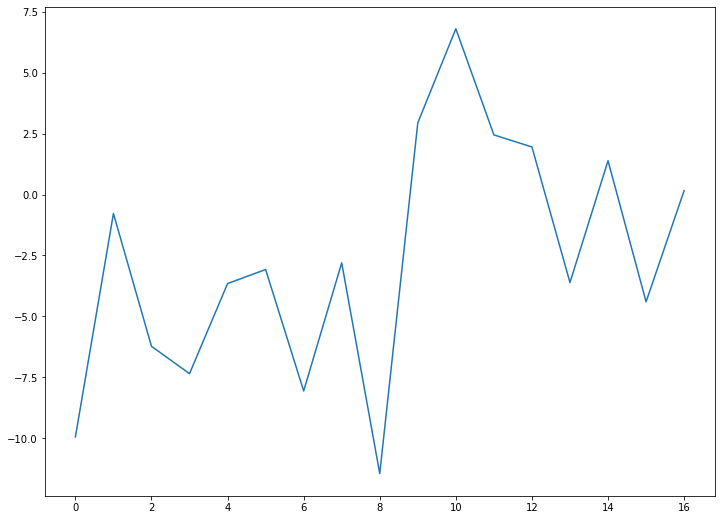

In [21]:
#  오차율 계산
diff= ((pred_test_y - target_test_sc)/ target_test_sc)*100

# 오차율 시각화
plt.figure(figsize=(12, 9))
plt.plot(diff)
plt.show()

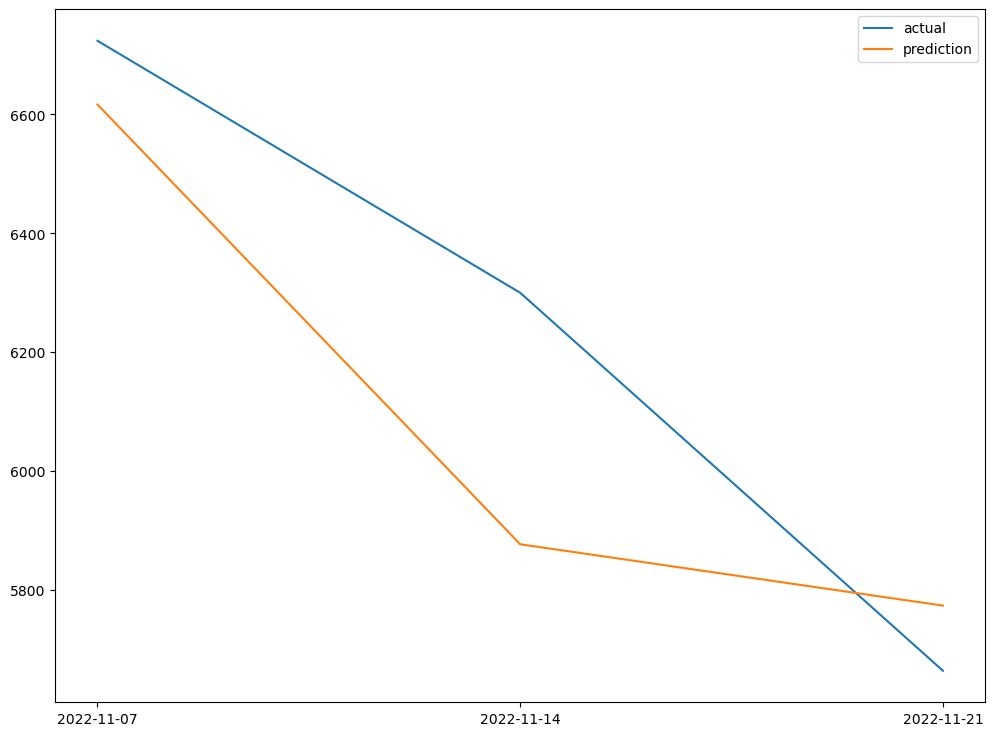

In [48]:
# 모델 불러오기
model= pickle.load(open('model/price_candle.pkl', 'rb'))

#예측
pred_test_y= model.predict(feature_test_sc)

# reshape
pred_test_y= pred_test_y.reshape(-1, 1)

# 예측 데이터 스케일링 복원
pred_test_y= scaler2.inverse_transform(pred_test_y)

# 실제 데이터 스케일링 복원
target_test_sc= scaler2.inverse_transform(target_test_sc)

# 예측 데이터 프레임 생성
pred_test_df= pd.DataFrame(pred_test_y, columns=['예측값'], index=feature_test_sc.index)

# 실제 데이터 프레임 생성
target_test_df= pd.DataFrame(target_test_sc, columns=['실제값'], index=feature_test_sc.index)

# 실제값, 예측값 데이터 프레임 병합
pred_test_df= pd.merge(pred_test_df, target_test_df, left_index=True, right_index=True)

#시각화
plt.figure(figsize=(12, 9))
plt.plot(pred_test_df['실제값'], label='actual')
plt.plot(pred_test_df['예측값'], label='prediction')
plt.legend()
plt.show()



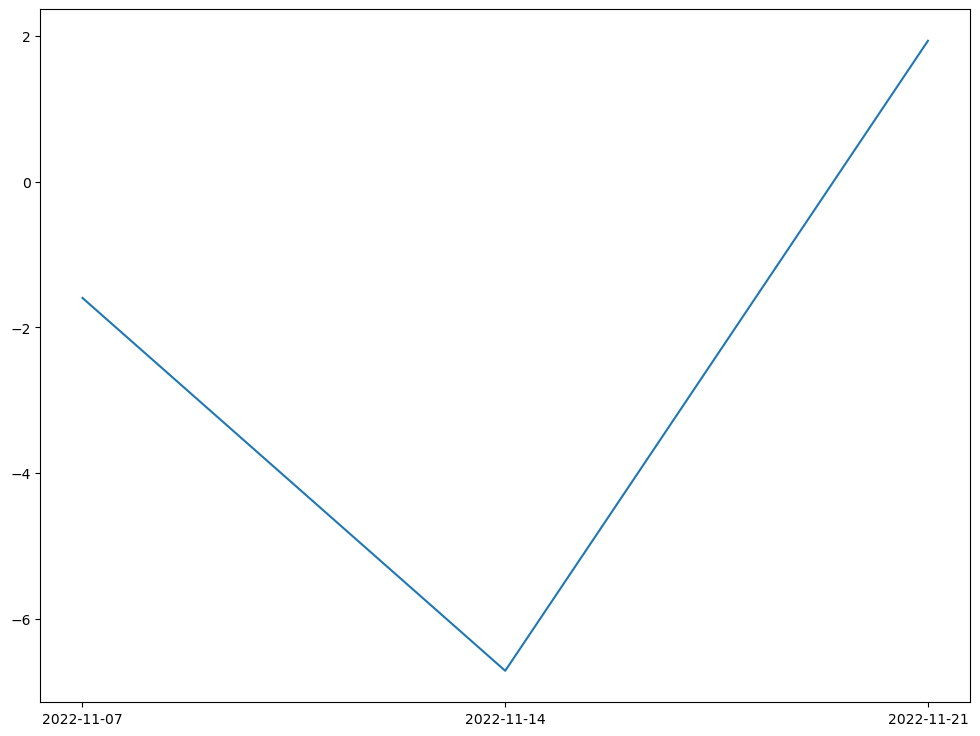

In [49]:
#  오차율 계산
pred_test_df['오차율']= (pred_test_df['예측값']-pred_test_df['실제값'])/pred_test_df['실제값']*100

# 오차율 시각화
plt.figure(figsize=(12, 9))
plt.plot(pred_test_df['오차율'])
plt.show()

